# Face recogintion
## Overview
Will will construct a layer with triplet loss to train the the model and use one shot learning to recognize the faces. We will use microsoft's 1M face dataset[72 per face dataset](https://github.com/microsoft/DigiFace1M/tree/main) from kaggle and base this notebook from [here](https://www.kaggle.com/code/stoicstatic/face-recognition-siamese-w-triplet-loss)

### Getting the dataset
Get and dowload dataset from [here](https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip)

In [1]:
!mkdir images && cd images

In [2]:
!wget https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip

--2023-10-01 14:57:32--  https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip
Resolving facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)... 20.38.109.4
Connecting to facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)|20.38.109.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2938553163 (2.7G) [application/octet-stream]
Saving to: ‘subjects_0-1999_72_imgs.zip’

subjects_0-1999_72_ 100%[===================>]   2.74G  12.2MB/s    in 5m 5s   

2023-10-01 15:02:37 (9.18 MB/s) - ‘subjects_0-1999_72_imgs.zip’ saved [2938553163/2938553163]



In [ ]:
!unzip subjects_0-1999_72_imgs.zip -d /content/images

Streaming output truncated to the last 5000 lines.
 extracting: /content/images/1930/45.png  
 extracting: /content/images/1930/46.png  
 extracting: /content/images/1930/47.png  
 extracting: /content/images/1930/48.png  
 extracting: /content/images/1930/49.png  
 extracting: /content/images/1930/5.png  
 extracting: /content/images/1930/50.png  
 extracting: /content/images/1930/51.png  
 extracting: /content/images/1930/52.png  
 extracting: /content/images/1930/53.png  
 extracting: /content/images/1930/54.png  
 extracting: /content/images/1930/55.png  
 extracting: /content/images/1930/56.png  
 extracting: /content/images/1930/57.png  
 extracting: /content/images/1930/58.png  
 extracting: /content/images/1930/59.png  
 extracting: /content/images/1930/6.png  
 extracting: /content/images/1930/60.png  
 extracting: /content/images/1930/61.png  
 extracting: /content/images/1930/62.png  
 extracting: /content/images/1930/63.png  
 extracting: /content/images/1930/64.png  
 extr

In [ ]:
!rm /content/subjects_0-1999_72_imgs.zip

### Preparing triplet training and testing data

In [ ]:
import os
import time
import random
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
ROOT = "/content/images"
WIDTH = 112
HEIGHT = 112

In [ ]:
def train_test_split(root, split=0.8):
  faces = os.listdir(root)
  train_faces_count = int(len(faces) * split)
  random.shuffle(faces)
  return faces[:train_faces_count], faces[train_faces_count:]

In [ ]:
def create_triplets(directory, folders, max_files=10):
    triplets = []

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.png")
                positive = (folder, f"{j}.png")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                # each folder has 71 images
                neg_file = random.randint(
                    0,
                    len(os.listdir(f"{directory}/{neg_folder}")) - 1
                  )
                negative = (neg_folder, f"{neg_file}.png")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [ ]:
train_list, test_list = train_test_split(ROOT)
train_triplet = create_triplets(ROOT, train_list, max_files=20)
test_triplet  = create_triplets(ROOT, test_list, max_files=20)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))
train_triplet[0:5]

Number of training triplets: 304000
Number of testing triplets : 76000


[(('877', '1.png'), ('877', '5.png'), ('806', '55.png')),
 (('902', '16.png'), ('902', '18.png'), ('229', '45.png')),
 (('1452', '5.png'), ('1452', '10.png'), ('726', '41.png')),
 (('1284', '8.png'), ('1284', '13.png'), ('1987', '38.png')),
 (('1282', '8.png'), ('1282', '15.png'), ('1657', '51.png'))]

#### Plots

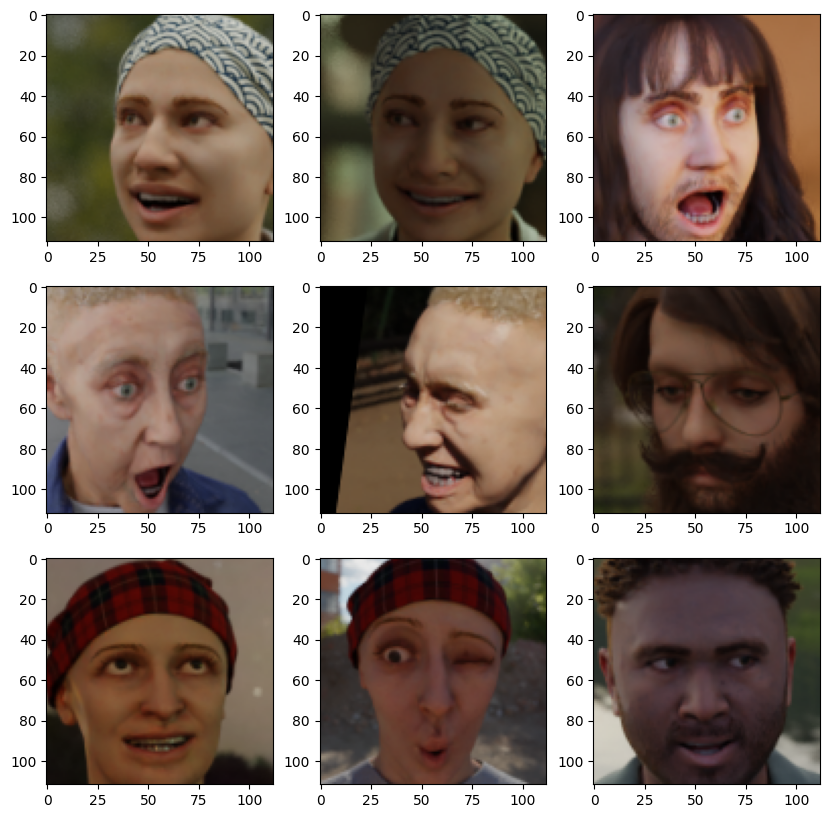

In [ ]:
number_of_example = 3
triplets = train_triplet

def read_img(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

f, axes = plt.subplots(number_of_example, 3, figsize=(10, 10))
i=0
for p,a,n in random.choices(triplets, k = number_of_example):
    axes[i, 0].imshow(read_img(os.path.join(ROOT, p[0], p[1])))
    axes[i, 1].imshow(read_img(os.path.join(ROOT, a[0], a[1])))
    axes[i, 2].imshow(read_img(os.path.join(ROOT, n[0], n[1])))
    i+=1

### Encodings
Use InceptionV3 to encode the the images and convert the file triplets to encoding triplets.

In [ ]:
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(WIDTH, HEIGHT, 3),
)
encoder = tf.keras.models.Sequential([
    inception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])
encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
def prepare(triplet_list):
  pl = []
  al = []
  nl = []
  for p,a,n in triplet_list:
    pl.append(os.path.join(ROOT, p[0], p[1]))
    al.append(os.path.join(ROOT, a[0], a[1]))
    nl.append(os.path.join(ROOT, n[0], n[1]))
  return pl, al, nl

def transform(file_path):
  image = tf.io.read_file(file_path)
  image = tf.io.decode_image(image, channels=3)
  image = tf.cast(image, tf.float32)
  return preprocess_input(image)

def get_encoding(triplet_list, encoder_batch=100):
  pl, al, nl = prepare(triplet_list)
  p_ds = tf.data.Dataset.from_tensor_slices(pl).map(transform).batch(
      encoder_batch)
  a_ds = tf.data.Dataset.from_tensor_slices(al).map(transform).batch(
      encoder_batch)
  n_ds = tf.data.Dataset.from_tensor_slices(nl).map(transform).batch(
      encoder_batch)
  print("Encoding positives")
  p_e = encoder.predict(p_ds)
  print("Encoding enchors")
  a_e = encoder.predict(a_ds)
  print("Encoding negatives")
  n_e = encoder.predict(n_ds)

  return tf.data.Dataset.zip((
      tf.data.Dataset.from_tensor_slices(p_e),
      tf.data.Dataset.from_tensor_slices(a_e),
      tf.data.Dataset.from_tensor_slices(n_e)
  ))


In [ ]:
train_encodings = get_encoding(train_triplet)
test_encodings = get_encoding(test_triplet)

Encoding positives
3040/3040 [==============================] - 246s 81ms/step
Encoding enchors
3040/3040 [==============================] - 237s 78ms/step
Encoding negatives
1525/3040 [==============>...............] - ETA: 3:18

### Simese Model
Now we will construct a simese model and train using triplet loss.

Triplet Loss Function:

$loss = \sum \limits _{i=1} ^ N[|f_i^a - f_i^p|_2^2 - |f_i^a - f_i^n|_2^2 + α]$

In [ ]:
class DistanceLayer(tf.keras.layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, positive, anchor, negative):
      ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
      an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
      return ap_distance , an_distance

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256,
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.L2(l2=0.4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256,
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.L2(l2=0.4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(125,
              activation="relu",
              kernel_regularizer=tf.keras.regularizers.L2(l2=0.1))
])

# Input Layers for the encoding
anchor_input   = tf.keras.layers.Input(2048, name="Anchor_Input")
positive_input = tf.keras.layers.Input(2048, name="Positive_Input")
negative_input = tf.keras.layers.Input(2048, name="Negative_Input")

## Generate the encodings (feature vectors) for the images
encoded_a = model(anchor_input)
encoded_p = model(positive_input)
encoded_n = model(negative_input)

## Calculate distance between anchor and positive/negative
distances = DistanceLayer()(encoded_p, encoded_a, encoded_n)

# Creating the Model
siamese_model = tf.keras.models.Model(
        inputs  = [positive_input, anchor_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )

siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Positive_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 Anchor_Input (InputLayer)      [(None, 2048)]       0           []                               
                                                                                                  
 Negative_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 sequential_5 (Sequential)      (None, 125)          557693      ['Anchor_Input[0][0]',           
                                                                  'Positive_Input[0]

In [ ]:
class TripletLoss(tf.keras.losses.Loss):
    def __init__(self, alpha, name="triplet_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.margin = alpha

    def call(self, ap_distance, an_distance):
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    def get_config(self):
        config = {
            'margin': self.margin
        }
        base_config = super().get_config()
        return {**base_config, **config}

def calc_accuracy(ap_d, an_d):
  count = ap_d.shape[0]
  return tf.reduce_sum(tf.cast(ap_d < an_d, dtype=tf.int16))/count

### Training

In [ ]:
NO_EPOCH = 50
BATCH_SIZE = 100
lr = 5e-3
alpha=1.0

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-01)
loss_eval = TripletLoss(alpha=alpha)
template = 'ETA: {} - epoch: {} loss: {:.5f} \
 acc: {:.3f}  val loss: {:.5f} val_acc: {:.3f}\n'

train_loss_metric = tf.keras.metrics.Mean(name="loss")
train_acc_metric = tf.keras.metrics.Mean(name="acc")
train_an_distance = tf.keras.metrics.Mean(name="an_d")
train_ap_distance = tf.keras.metrics.Mean(name="ap_d")

test_loss_metric = tf.keras.metrics.Mean(name="loss")
test_acc_metric = tf.keras.metrics.Mean(name="acc")
test_an_distance = tf.keras.metrics.Mean(name="an_d")
test_ap_distance = tf.keras.metrics.Mean(name="ap_d")

metrics = []

# start training loop
for ep in range(1,NO_EPOCH+1):
  t = time.time()
  # training batch
  for n,a,p in train_encodings.batch(BATCH_SIZE):
    with tf.GradientTape() as tape:
      ap_d, an_d = siamese_model([n,a,p])
      train_loss = loss_eval(ap_d, an_d)
    grads = tape.gradient(train_loss, siamese_model.trainable_weights)
    optimizer.apply_gradients(
        zip(grads, siamese_model.trainable_weights)
    )
    train_loss_metric.update_state(train_loss)
    train_ap_distance.update_state(ap_d)
    train_an_distance.update_state(an_d)
    train_acc_metric.update_state(
        calc_accuracy(ap_d,an_d)
    )
  # testing batch
  for n,a,p in test_encodings.batch(BATCH_SIZE):
    ap_d, an_d = siamese_model([n,a,p])
    test_loss = loss_eval(ap_d, an_d)
    test_loss_metric.update_state(test_loss)
    test_ap_distance.update_state(ap_d)
    test_an_distance.update_state(an_d)
    test_acc_metric.update_state(
        calc_accuracy(ap_d, an_d)
    )

  print(template.format(
      round(time.time() - t),
      ep,
      float(train_loss_metric.result()),
      float(train_acc_metric.result()),
      float(test_loss_metric.result()),
      float(test_acc_metric.result())
  ))
  metrics.append({
      "train_loss": train_loss_metric.result(),
      "test_loss": test_loss_metric.result(),
      "train_acc": train_acc_metric.result(),
      "test_acc": test_acc_metric.result(),
      "train_ap": train_ap_distance.result(),
      "test_ap": test_ap_distance.result(),
      "train_an": train_an_distance.result(),
      "test_an": test_an_distance.result()
  })
  # clearing the metric values
  train_loss_metric.reset_states()
  train_acc_metric.reset_states()
  train_ap_distance.reset_states()
  train_an_distance.reset_states()
  test_loss_metric.reset_states()
  test_acc_metric.reset_states()
  test_ap_distance.reset_states()
  test_an_distance.reset_states()




ETA: 8 - epoch: 1 loss: 0.98790  acc: 0.793  val loss: 0.48286 val_acc: 0.817

ETA: 7 - epoch: 2 loss: 0.33798  acc: 0.865  val loss: 0.38791 val_acc: 0.849

ETA: 11 - epoch: 3 loss: 0.25426  acc: 0.900  val loss: 0.38023 val_acc: 0.854

ETA: 7 - epoch: 4 loss: 0.21212  acc: 0.916  val loss: 0.39928 val_acc: 0.855

ETA: 7 - epoch: 5 loss: 0.18370  acc: 0.928  val loss: 0.39916 val_acc: 0.866

ETA: 11 - epoch: 6 loss: 0.14583  acc: 0.945  val loss: 0.42419 val_acc: 0.860

ETA: 11 - epoch: 7 loss: 0.12215  acc: 0.954  val loss: 0.44316 val_acc: 0.858

ETA: 11 - epoch: 8 loss: 0.11917  acc: 0.953  val loss: 0.45917 val_acc: 0.870

ETA: 7 - epoch: 9 loss: 0.10225  acc: 0.961  val loss: 0.45162 val_acc: 0.871

ETA: 7 - epoch: 10 loss: 0.09778  acc: 0.963  val loss: 0.50766 val_acc: 0.874

ETA: 7 - epoch: 11 loss: 0.09182  acc: 0.965  val loss: 0.49675 val_acc: 0.866

ETA: 6 - epoch: 12 loss: 0.08554  acc: 0.968  val loss: 0.51488 val_acc: 0.877

ETA: 7 - epoch: 13 loss: 0.07482  acc: 0.972 

### Plotting the result

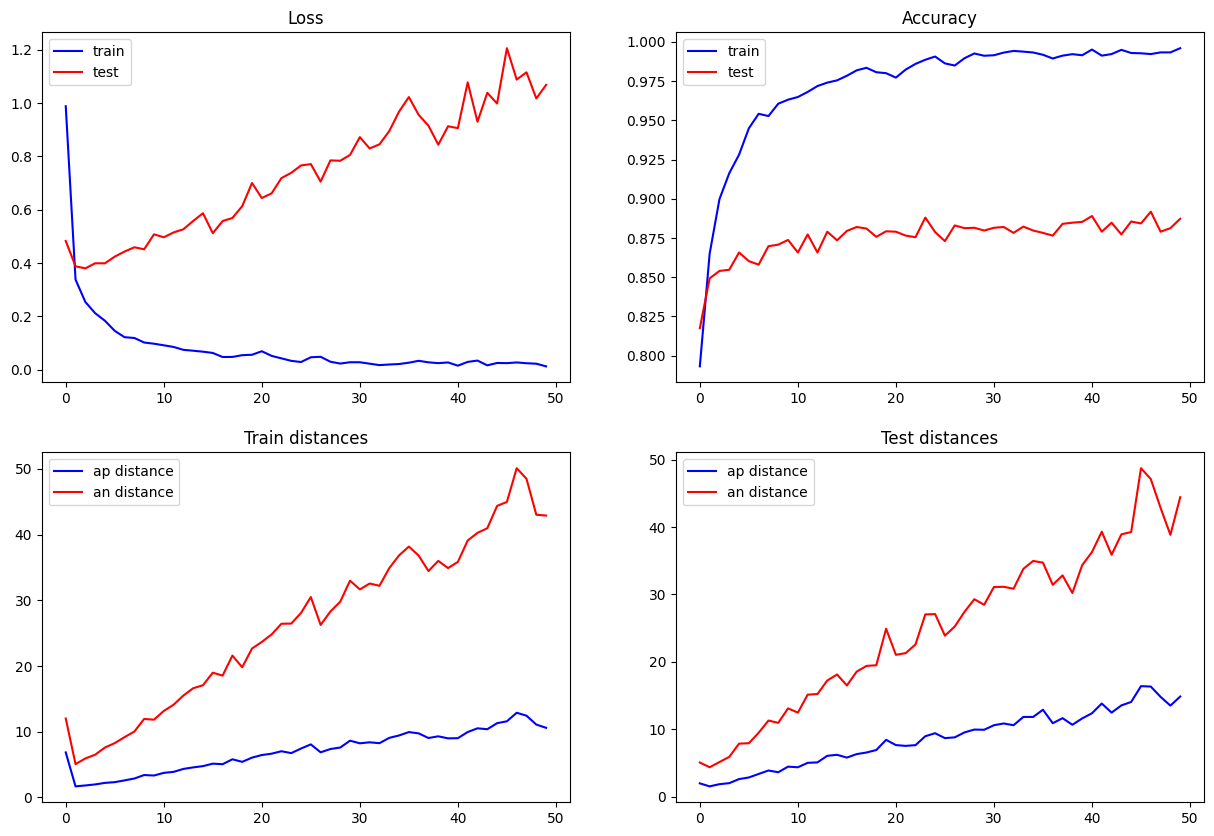

In [ ]:
plt.figure(figsize=(15,10))

# Plotting the loss over epochs
plt.subplot(221)
plt.plot(list(map(lambda x: x['train_loss'], metrics)), 'b', label='train')
plt.plot(list(map(lambda x: x['test_loss'], metrics)), 'r', label='test')
plt.title('Loss')
plt.legend()

# Plotting the accuracy over epochs
plt.subplot(222)
plt.plot(list(map(lambda x: x['train_acc'], metrics)), 'b', label='train')
plt.plot(list(map(lambda x: x['test_acc'], metrics)), 'r', label='test')
plt.title('Accuracy')
plt.legend()

# Plotting the distances over epochs
plt.subplot(223)
plt.plot(list(map(lambda x: x['train_ap'], metrics)), 'b', label='ap distance')
plt.plot(list(map(lambda x: x['train_an'], metrics)), 'r', label='an distance')
plt.title('Train distances')
plt.legend()

# Plotting the distances over epochs
plt.subplot(224)
plt.plot(list(map(lambda x: x['test_ap'], metrics)), 'b', label='ap distance')
plt.plot(list(map(lambda x: x['test_an'], metrics)), 'r', label='an distance')
plt.title('Test distances')
plt.legend()

plt.show()

In [ ]:
model.save('encoder')